## DATA 780: Final Project Bagging

Features:
* ID: Unique identifier for each student
* Demographics: Age, Gender, City
* Academic Indicators: CGPA, Academic Pressure, Study Satisfaction
* Lifestyle & Wellbeing: Sleep Duration, Dietary Habits, Work Pressure, Job Satisfaction, Work/Study Hours
* Additional Factors: Profession, Degree, Financial Stress, Family History of Mental Illness, and whether the student has ever had suicidal thoughts


Target Variable:
* Depression_Status: A binary indicator (0/1 or Yes/No) that denotes whether a student is experiencing depression

In [ ]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import shap
from sklearn.metrics import ConfusionMatrixDisplay

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adilshamim8/student-depression-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/taylorbaldwin/.cache/kagglehub/datasets/adilshamim8/student-depression-dataset/versions/1


In [6]:
data = pd.read_csv(path + '/student_depression_dataset.csv')
data.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

In [8]:
# Rename Columns
data = data.rename(columns={'CGPA':'Cumulative GPA'})
data = data.rename(columns={'Have you ever had suicidal thoughts ?' : 'Suicidal thoughts'})
data = data.rename(columns={'Family History of Mental Illness': 'Mental Illness History'})

In [9]:
# Clean column names
data.columns = data.columns.str.strip().str.replace(' ', '_').str.replace('?', '').str.replace('/', '_')

In [10]:
# Clean columns value text

#removing blank spaces
data.columns=data.columns.str.replace(' ', '_')
data.replace(' ','_', regex=True, inplace=True)
#removing '' from the sleep duaration output
data['Sleep_Duration'] = data['Sleep_Duration'].str.replace("'", "", regex=False)
data.head()

,id,Gender,Age,City,Profession,Academic_Pressure,Work_Pressure,Cumulative_GPA,Study_Satisfaction,Job_Satisfaction,Sleep_Duration,Dietary_Habits,Degree,Suicidal_thoughts,Work_Study_Hours,Financial_Stress,Mental_Illness_History,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6_hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6_hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less_than_5_hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8_hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6_hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


In [11]:
# Drop columns too granular
data = data.drop(columns=['id', 'City'], errors='ignore')

data.head()


,Gender,Age,Profession,Academic_Pressure,Work_Pressure,Cumulative_GPA,Study_Satisfaction,Job_Satisfaction,Sleep_Duration,Dietary_Habits,Degree,Suicidal_thoughts,Work_Study_Hours,Financial_Stress,Mental_Illness_History,Depression
0,Male,33.0,Student,5.0,0.0,8.97,2.0,0.0,5-6_hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,Female,24.0,Student,2.0,0.0,5.90,5.0,0.0,5-6_hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,Male,31.0,Student,3.0,0.0,7.03,5.0,0.0,Less_than_5_hours,Healthy,BA,No,9.0,1.0,Yes,0
3,Female,28.0,Student,3.0,0.0,5.59,2.0,0.0,7-8_hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,Female,25.0,Student,4.0,0.0,8.13,3.0,0.0,5-6_hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


## Split Data into Training and Testing Sets

In [12]:
# Assign Columns to feature and target variables
X = data.drop('Depression', axis = 1).copy() # Features
y = data['Depression'].copy() # Target

In [13]:
# One hot encoding
X_encoded = pd.get_dummies(X, drop_first=True)
X_encoded.head()

,Age,Academic_Pressure,Work_Pressure,Cumulative_GPA,Study_Satisfaction,Job_Satisfaction,Work_Study_Hours,Gender_Male,Profession_'Content_Writer',Profession_'Digital_Marketer',...,Degree_MSc,Degree_Others,Degree_PhD,Suicidal_thoughts_Yes,Financial_Stress_2.0,Financial_Stress_3.0,Financial_Stress_4.0,Financial_Stress_5.0,Financial_Stress_?,Mental_Illness_History_Yes
0,33.0,5.0,0.0,8.97,2.0,0.0,3.0,True,False,False,...,False,False,False,True,False,False,False,False,False,False
1,24.0,2.0,0.0,5.90,5.0,0.0,3.0,False,False,False,...,False,False,False,False,True,False,False,False,False,True
2,31.0,3.0,0.0,7.03,5.0,0.0,9.0,True,False,False,...,False,False,False,False,False,False,False,False,False,True
3,28.0,3.0,0.0,5.59,2.0,0.0,4.0,False,False,False,...,False,False,False,True,False,False,False,True,False,True
4,25.0,4.0,0.0,8.13,3.0,0.0,1.0,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [32]:
# Prepare training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.3, random_state = 42)

In [33]:
# Bagging Classifier with Decision Tree estimator
bagging = BaggingClassifier(
    estimator = DecisionTreeClassifier(max_depth=6),
    n_estimators = 100,
    random_state = 42
)

In [34]:
# Fit the Model
bagging.fit(X_train, y_train)

,estimator,DecisionTreeC...r(max_depth=6)
,n_estimators,100
,max_samples,1.0
,max_features,1.0
,bootstrap,True
,bootstrap_features,False
,oob_score,False
,warm_start,False
,n_jobs,None
,random_state,42
,verbose,0


In [35]:
# Predict
y_pred = bagging.predict(X_test)

## Bagging Classifier Evaluation

In [36]:
# Model Evaluation - Accuracy and Classification Report
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n",classification_report(y_test, y_pred))

Accuracy:  0.8260661808625015
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.77      0.79      3505
           1       0.84      0.87      0.85      4866

    accuracy                           0.83      8371
   macro avg       0.82      0.82      0.82      8371
weighted avg       0.83      0.83      0.83      8371



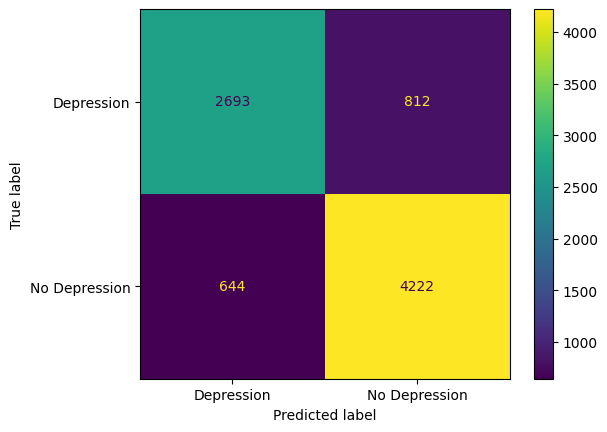

In [37]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(bagging,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=["Depression","No Depression"])

## Feature Importance (SHAP Metrics)

In [38]:
# SHAP Values for Bagging Classifier
all_shap_values = []

for est in bagging.estimators_:
    explainer = shap.TreeExplainer(est)
    values = explainer.shap_values(X_test)
    all_shap_values.append(values)

mean_shap = np.mean(np.array(all_shap_values), axis=0)

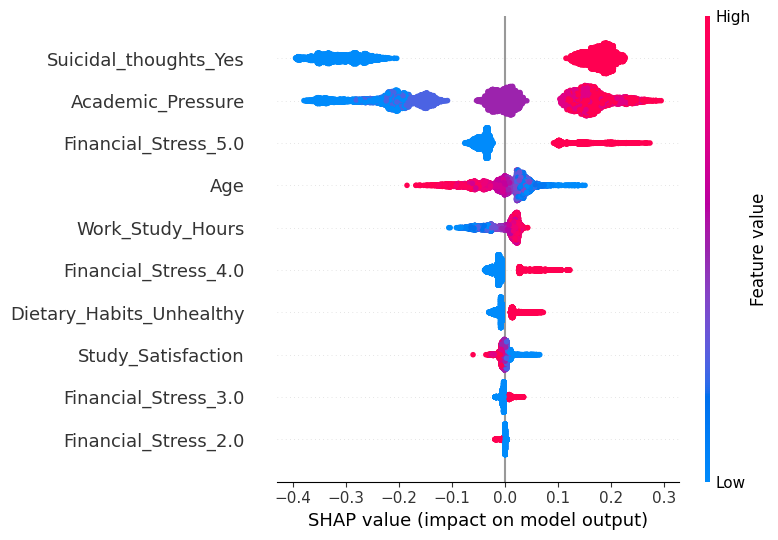

In [39]:
shap_values_class1 = mean_shap[:, :, 1]

# Summary Plot -- Default (dot plot)
shap.summary_plot(shap_values_class1, X_test, feature_names=X_encoded.columns, max_display=10)

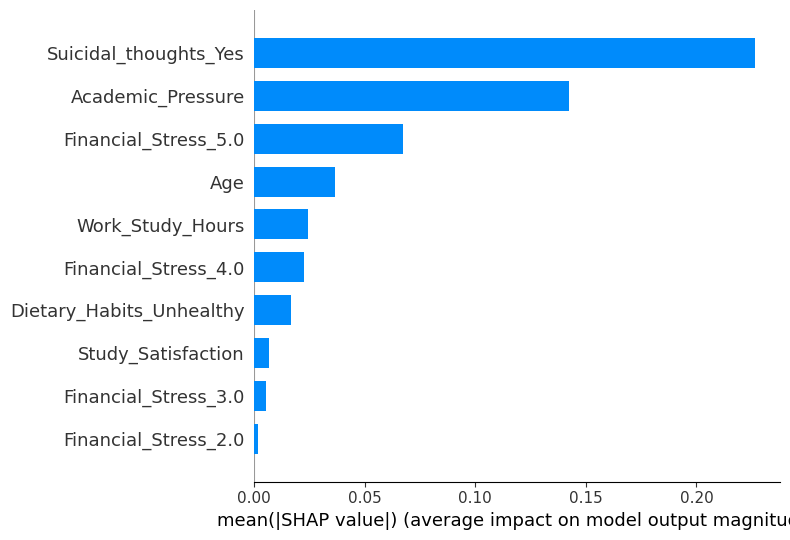

In [40]:
# Summary Plot -- Bar Chart
shap.summary_plot(shap_values_class1, X_test, plot_type="bar", feature_names=X_encoded.columns, max_display= 10)